# Using `pytorch`

## Lecture plan

- Working with a CSS dataset in `pytorch`.
- Relevant considerations:
   - Model **architecture**.
   - Type of **activation function**.
   - Number of **epochs**.


## Working with a CSS dataset

- Last time, we discussed building a model in `pytorch`.
- But we used a dataset that wasn't as interesting for CSS...
- Now, we'll discuss how to adapt one of our CSS datasets to classification with a neural network.

### Loading our dataset

We'll use a **Political Science** dataset analyzing votes from a [1988 referendum in Chile](https://en.wikipedia.org/wiki/1988_Chilean_presidential_referendum).

> A referendum on whether Augusto Pinochet, the head of a military dictatorship, should become president for eight years under resumed civilian rule was held in Chile on October 5, 1988. The "No" side won with 56% of the vote, marking the end of Pinochet's 16+1⁄2-year rule. Democratic elections were held in 1989, leading to the establishment of a new government in 1990.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_chile = pd.read_csv("data/classification/chilesurvey.csv")
df_chile.head(2)

,region,population,sex,age,education,income,statusquo,vote,logincome,logpop,sex_M,region_M,region_N,region_S,region_SA,education_PS,education_S
0,N,175000,M,65.0,P,35000.0,1.00820,Y,10.463103,12.072541,True,False,True,False,False,False,False
1,N,175000,M,29.0,PS,7500.0,-1.29617,N,8.922658,12.072541,True,False,True,False,False,True,False


In [3]:
df_chile.shape

(2431, 17)

#### Inspecting our dataset

- We can inspect the distribution of **votes**.
- In this full dataset, we'll include `U` (undecided) and `A` (abstain).

In [4]:
df_chile['vote'].value_counts() / len(df_chile)

vote
N    0.356643
Y    0.343891
U    0.226656
A    0.072810
Name: count, dtype: float64

#### Adapting our dataset

- We'll need to **adapting** our dataset to be used with `pytorch`.
- This will involve a few steps:
   - Use only the *numerical* encodings of categorical features.
   - Separate our features and our labels.
   - Create a `ChileDataset` class to make batching easier.

In [5]:
# Convert boolean columns to integers
boolean_columns = df_chile.select_dtypes(include=['bool']).columns
df_chile[boolean_columns] = df_chile[boolean_columns].astype(int)

In [6]:
# Separate features and labels
features = df_chile.drop(columns=['vote', 'region', 'sex', 'education'])
labels = df_chile['vote']

#### Transform labels

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
le_vote = LabelEncoder()
labels = le_vote.fit_transform(labels)
labels

array([3, 1, 3, ..., 3, 3, 3])

#### Create a custom `ChileDataset` class

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

In [10]:
# Custom Dataset Class
class ChileDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [11]:
dataset = ChileDataset(features, labels)
type(dataset)

__main__.ChileDataset

#### Check that it works with `DataLoader`

In [12]:
# Create DataLoader
batch_size = 30
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Set up neural network!

- Now, we need to create a `NeuralNetwork` class.
- Recall that we can subclass the `nn.Module`.

**Check-in**: What should the *dimensions* of our layers be?

In [13]:
import torch.nn as nn
import torch.optim as optim

#### Creating a `NeuralNetwork` class

- Our input layer should have dimension `input_size`.
- Our output layer should have dimension `output_size`.
- We can choose `hidden_size`.
- Here, we also add something called `Dropout`, which randomly *zeroes* some elements of the input with some probability; can make model more **robust**.

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

#### Instantiating a `NeuralNetwork`

In [15]:
# Set up components
input_size = features.shape[1]  # Number of features
output_size = len(np.unique(labels))  # Number of classes
hidden_size = 200  # Number of neurons in the hidden layer

In [16]:
# Instantiate model
model = NeuralNetwork(input_size, hidden_size, output_size)

In [17]:
model

NeuralNetwork(
  (fc1): Linear(in_features=13, out_features=200, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=200, out_features=4, bias=True)
)

### Set up our *training regime*

- Now, we need to define our `train_loop` and `test_loop`.
- We already set this up last time, so we can just use the same logic.

#### Our `train_loop`

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            

#### Our `test_loop`

In [19]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return test_loss, correct

#### Divide data into train/test

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, random_state=42)

In [22]:
### Create ChileDataset
train_dataset = ChileDataset(X_train, y_train)
test_dataset = ChileDataset(X_test, y_test)

In [23]:
### Create DataLoaders
batch_size = 100
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#### Set up hyper-parameters

- We'll use **cross-entropy loss**.
- We'll start out with this `learning_rate` and `10` epochs.

In [42]:
num_epochs = 20  # Number of epochs for training
learning_rate = 0.001  # Learning rate

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Time to train!

In [44]:
results = []
for t in range(num_epochs):
    train_loop(train_dataloader, model, criterion, optimizer)
    test_loss, correct = test_loop(test_dataloader, model, criterion)
    results.append({
        'epoch': t,
        'test_loss': test_loss,
        'accuracy': correct})
print("Done!")

Done!


In [45]:
df_results = pd.DataFrame(results)

#### Visualize results

In [46]:
import seaborn as sns

<Axes: xlabel='epoch', ylabel='test_loss'>

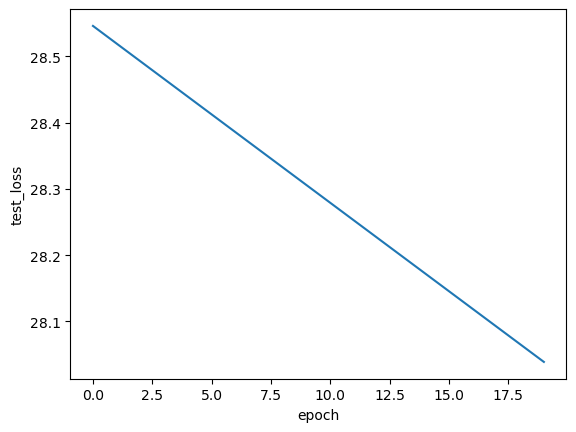

In [47]:
sns.lineplot(data = df_results, x = "epoch", y = "test_loss")

#### The trajectory of performance

- In general, *loss* should decrease over time.
- But performance may stall out, and not seem that impressive.
- Sometimes, other models (like an SVM) are more efficient and perform just as well (if not better)!

## The alchemy of neural networks

There are all sorts of considerations when building neural networks. 

- Which model **architecture**?
   - Also includes questions about *dropout*, etc.
- Which **activation function**?
- Which **batch size**?
- Which **learning rate**?
- Which **number of epochs**?

As with many aspects of model building, some of this is an *empirical question*. What works best?

## Lecture wrap-up

- This lecture only *scratched the surface* of working with datasets in `pytorch`.
    - Many other libraries, like `keras` or `tensorflow`.
- We used a very simple (and naive) `NeuralNetwork` architecture.
- But now you have a general sense for what goes on under the hood.